# IAU Projekt - Fáza 4 - Aktivity na cvičení
Peter Brenkus, Tomáš Brček

Percentuálny podiel: 50/50

In [49]:
import os
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

In [106]:
IMAGE_SIZE = 128
BATCH_SIZE = 16

base_path = "data/head_ct"

# 4.1 EDA and data preprocessing

## A

EDA a data preprocessing pre Vami vybrané charakteristiky z datasetu

In [94]:
labels = pd.read_csv("data/labels.csv", index_col="id")

In [95]:
files = sorted(os.listdir(path=base_path))
normal_imgs = [fn for i, fn in enumerate(files) if (labels.loc[i, ' hemorrhage'] == 0)]
hemorrhage_imgs = [fn for i, fn in enumerate(files) if (labels.loc[i, ' hemorrhage'] == 1)]
print(f'Num. normal: {len(normal_imgs)}, num. hemorrhage: {len(hemorrhage_imgs)}')

Num. normal: 100, num. hemorrhage: 100


Môžeme vidieť, že medzi obrázkami máme 100 takých, ktoré sú normálne a 100 takých, na ktorých je krvácanie. Tieto triedy sme si rozdelili do 2 polí.

### Zobrazenie vzorky

In [29]:
normal_selection = np.random.choice(normal_imgs, 5, replace = False)
hemorrhage_selection = np.random.choice(hemorrhage_imgs, 5, replace = False)

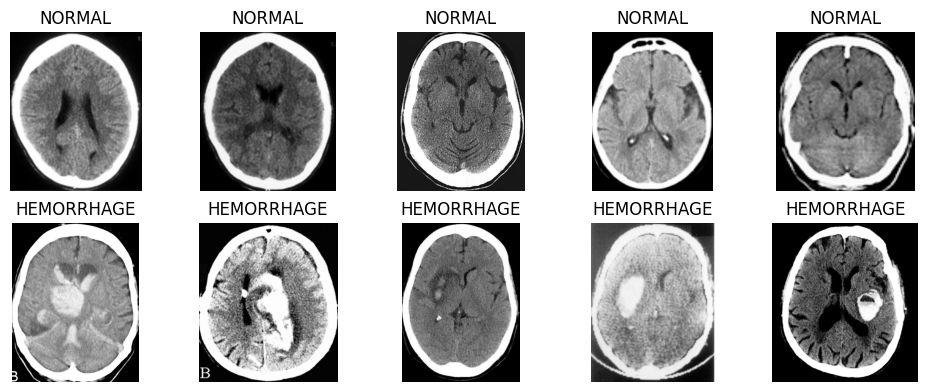

In [30]:
fig = plt.figure(figsize=(12, 12)) 
for i in range(10):
    if i < 5:
        fp = f'data/head_ct/{normal_selection[i]}'
        label = 'NORMAL'
    else:
        fp = f'data/head_ct/{hemorrhage_selection[i-6]}'
        label = 'HEMORRHAGE'
    ax = fig.add_subplot(5, 5, i+1)
    
    fn = image.load_img(fp, color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

Vybrali sme vzorku 5 obrázkov z každej triedy, ktoré sme si vykreslili pre lepšiu predstavu.

### Zobrazenie priemerného príkladu

In [31]:
def convert_images_to_matrix(directory, filenames, size=(IMAGE_SIZE, IMAGE_SIZE)):
    full_matrix = None
    for filename in filenames:
        file_path = os.path.join(directory, filename)
        loaded_image = image.load_img(file_path, target_size=size, color_mode='grayscale')
        image_array = image.img_to_array(loaded_image).ravel()[np.newaxis, :]
        if full_matrix is None:
            full_matrix = image_array
        else:
            full_matrix = np.vstack((full_matrix, image_array))
    return full_matrix

normal = convert_images_to_matrix('data/head_ct/', normal_imgs)
hemorrhage = convert_images_to_matrix('data/head_ct/', hemorrhage_imgs)

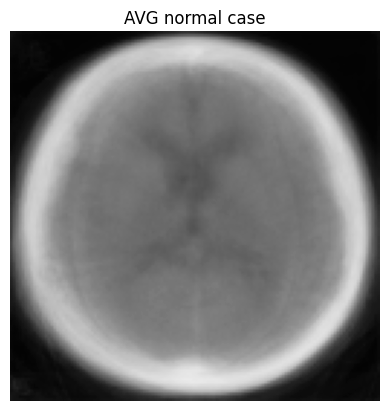

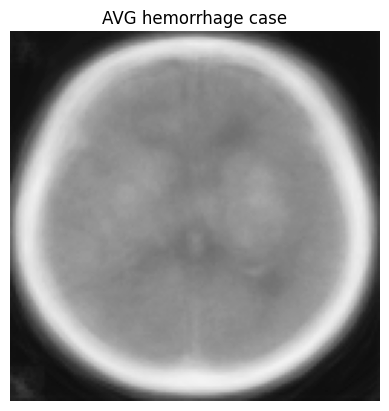

In [32]:
def find_mean_img(full_mat, title, size=(IMAGE_SIZE, IMAGE_SIZE)):
    mean_img = np.mean(full_mat, axis = 0)
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'AVG {title} case')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean_img = find_mean_img(normal, 'normal')
hemorrhage_mean_img = find_mean_img(hemorrhage, 'hemorrhage')

Na obrázkoch vyššie môžeme vidieť priemerné prípady pre normálne snímky, a pre snímky, ktoré obsahujú krvácanie. 

### Príprava datasetu

In [96]:
def load_image_and_label(image_name, label):
    img_path = tf.strings.join([base_path, image_name], separator="/")
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
    img = img / 255.0
    return img, label

In [97]:
normal_labels = [0] * len(normal_imgs)
normal_dataset = tf.data.Dataset.from_tensor_slices((normal_imgs, normal_labels))
normal_dataset = normal_dataset.map(load_image_and_label)

In [98]:
hemorrhage_labels = [1] * len(hemorrhage_imgs)
hemorrhage_dataset = tf.data.Dataset.from_tensor_slices((hemorrhage_imgs, hemorrhage_labels))
hemorrhage_dataset = hemorrhage_dataset.map(load_image_and_label)

In [99]:
full_dataset = normal_dataset.concatenate(hemorrhage_dataset)
full_dataset = full_dataset.shuffle(buffer_size=len(full_dataset))


#### Rozdelenie na trénovacie a testovacie dáta

In [107]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset = full_dataset.take(train_size).batch(BATCH_SIZE)
val_dataset = full_dataset.skip(train_size).take(val_size).batch(BATCH_SIZE)
test_dataset = full_dataset.skip(train_size).skip(val_size).batch(BATCH_SIZE)

In [38]:
input_shape = None
for batch, labels in train_dataset.take(1):
    input_shape = batch.shape
    print(input_shape)
    print(labels.numpy())

(16, 128, 128, 1)
[0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1]


2024-12-01 18:25:41.312510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


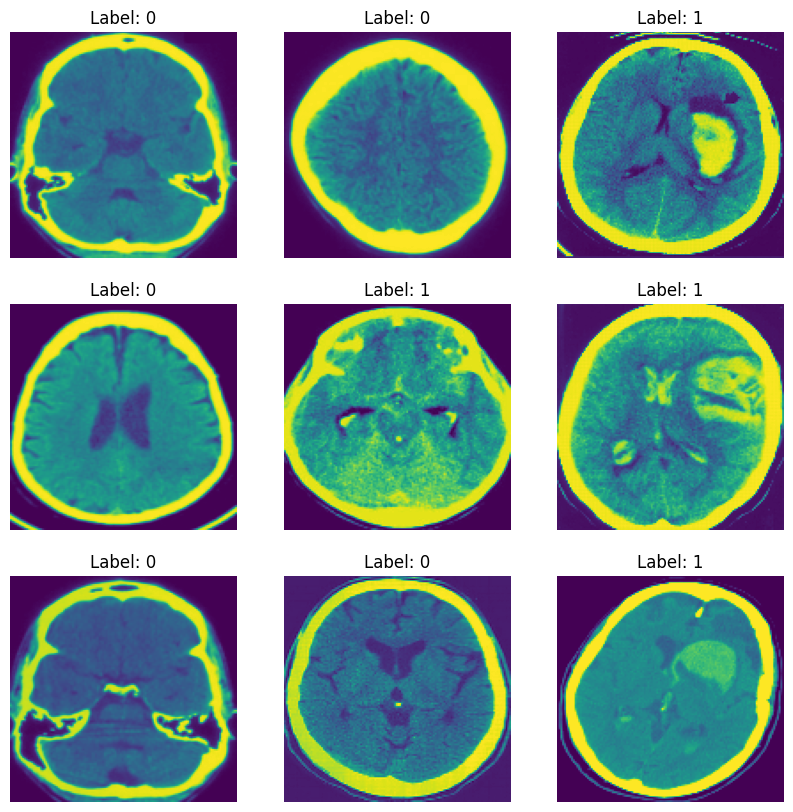

2024-12-01 18:25:42.100447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [39]:
for img, label in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, img.shape[0])):
        plt.subplot(3, 3, i + 1)
        plt.imshow(img[i])
        plt.title(f"Label: {label[i].numpy()}")
        plt.axis("off")
    plt.show()

Na obrázkoch vyššie je zobrazený prvý batch pre trénovacie dáta.

## B

Zdôvodnite výber ML/DL metód vzhľadom na Vami vybraný dataset pre 4.2

# 4.2 Modeling and evaluation

## A

Modeluje Vami tie vybrané charakteristiky pomocou vhodných ML/DL metód. Výsledok modelovania je najlepší model.

In [40]:
import optuna

def objective(trial):
    model = tf.keras.Sequential()
    model.add(layers.Rescaling(1./255, input_shape=(128, 128, 1)))
    model.add(layers.Conv2D(trial.suggest_int('filters', 16, 64, step=16), (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(trial.suggest_int('units', 32, 128, step=32), activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=0)
    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best parameters:", study.best_params)

/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-01 18:25:42,409] A new study created in memory with name: no-name-ec14e5e9-a5e3-430c-97f3-2dedc7d4733f
/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2024-12-01 18:25:55,331] Trial 0 finished with value: 0.4749999940395355 and parameters: {'filters': 32, 'units': 64, 'learning_rate': 0.0014081740255628642}. Best is trial 0 with value: 0.4749999940395355.
[I 2024-12-01 18:26:03,317] Trial 1 finished with 

Best parameters: {'filters': 48, 'units': 128, 'learning_rate': 0.001735001120613693}


In [108]:
from tensorflow.keras import layers, Sequential

model = Sequential([
    layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)), 
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.2), 
    layers.Dense(64, activation='relu'), 
    layers.Dense(1, activation='sigmoid')
])

In [109]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [110]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=30)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - accuracy: 0.4728 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.5145 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4685 - loss: 0.6933 - val_accuracy: 0.4250 - val_loss: 0.6933
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.5242 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.5100 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6931
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.5445 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.4544 - loss: 0.6935 - val_accuracy: 0.4750 - val_loss: 0.6931
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.5065 - loss: 0.6930 - val_accuracy: 0.6000 - val_loss

In [111]:
test_loss, test_acc = model.evaluate(test_dataset)
test_acc

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8375 - loss: 0.4927 


0.8500000238418579

In [112]:
train_loss, train_acc = model.evaluate(train_dataset)
train_acc

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8067 - loss: 0.5072


0.7785714268684387

In [1]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: xbrenkus (xbrenkus-slovak-university-of-technology). Use `wandb login --relogin` to force relogin


True

In [113]:
def train_model(config=None):
    with wandb.init(config=config):
        config = wandb.config 
        
        model = tf.keras.Sequential([
            layers.Rescaling(1./255, input_shape=(128, 128, 1)),
            layers.Conv2D(config.filters, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(config.filters, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(config.units, activation='relu'),
            layers.Dropout(config.dropout),
            layers.Dense(1, activation='sigmoid')
        ])

        optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=config.epochs,
            batch_size=config.batch_size
        )

        wandb.log({
            "train_accuracy": history.history['accuracy'][-1],
            "val_accuracy": history.history['val_accuracy'][-1],
            "train_loss": history.history['loss'][-1],
            "val_loss": history.history['val_loss'][-1],
        })

In [114]:
sweep_config = {
    'method': 'random', 
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'filters': {
            'values': [32, 48, 64]
        },
        'units': {
            'values': [64, 80, 96]
        },
        'dropout': {
            'values': [0.1, 0.15, 0.2, 0.25]
        },
        'learning_rate': {
            'distribution': 'uniform',
            'min': 0.0005,
            'max': 0.001
        },
        'epochs': {
            'values': [20, 25, 30]
        },
        'batch_size': {
            'values': [20, 24, 28]
        }
    }
}

In [115]:
sweep_id = wandb.sweep(sweep_config, project="IAU_F4")

Create sweep with ID: 0yvp1mxc
Sweep URL: https://wandb.ai/IAU_F4/IAU_F4/sweeps/0yvp1mxc


In [116]:
wandb.agent(sweep_id, function=train_model, count=100)

wandb: Agent Starting Run: hks608id with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.1
wandb: 	epochs: 20
wandb: 	filters: 48
wandb: 	learning_rate: 0.0005487096184688786
wandb: 	units: 64


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.4211 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.5006 - loss: 0.6936 - val_accuracy: 0.4750 - val_loss: 0.6936
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.3958 - loss: 0.6940 - val_accuracy: 0.6000 - val_loss: 0.6930
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.4915 - loss: 0.6932 - val_accuracy: 0.3750 - val_loss: 0.6933
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.4555 - loss: 0.6932 - val_accuracy: 0.6750 - val_loss: 0.6929
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.4374 - loss: 0.6932 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.5233 - loss: 0.6932 - val_accuracy: 0.4250 - val_loss: 0.6933
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.3928 - loss: 0.6933 - val_accuracy: 0.4750 - val_loss: 0.6931
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.49286
train_loss,0.69321
val_accuracy,0.45
val_loss,0.69344


wandb: Agent Starting Run: lokyp6sd with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.1
wandb: 	epochs: 25
wandb: 	filters: 32
wandb: 	learning_rate: 0.0005740609643594043
wandb: 	units: 80


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.5302 - loss: 0.6932 - val_accuracy: 0.5250 - val_loss: 0.6923
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.5255 - loss: 0.6928 - val_accuracy: 0.5250 - val_loss: 0.6924
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.5484 - loss: 0.6923 - val_accuracy: 0.4000 - val_loss: 0.6953
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.4715 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.5998 - loss: 0.6923 - val_accuracy: 0.5500 - val_loss: 0.6913
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.4194 - loss: 0.6953 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.5064 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6929
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.5790 - loss: 0.6927 - val_accuracy: 0.4750 - val_loss: 0.6934
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.65
train_loss,0.67809
val_accuracy,0.4
val_loss,0.69515


wandb: Agent Starting Run: trap0obf with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.1
wandb: 	epochs: 30
wandb: 	filters: 64
wandb: 	learning_rate: 0.0007025826848334513
wandb: 	units: 64


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.5685 - loss: 0.6937 - val_accuracy: 0.6250 - val_loss: 0.6925
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.4953 - loss: 0.6932 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.5477 - loss: 0.6931 - val_accuracy: 0.6250 - val_loss: 0.6925
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.5175 - loss: 0.6931 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.4570 - loss: 0.6932 - val_accuracy: 0.4000 - val_loss: 0.6933
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.4395 - loss: 0.6933 - val_accuracy: 0.6250 - val_loss: 0.6931
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.5247 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.5305 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.48571
train_loss,0.69317
val_accuracy,0.4
val_loss,0.69331


wandb: Agent Starting Run: 9m8lb5h7 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.1
wandb: 	epochs: 20
wandb: 	filters: 48
wandb: 	learning_rate: 0.000644873000918337
wandb: 	units: 80


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.4258 - loss: 0.6935 - val_accuracy: 0.6000 - val_loss: 0.6930
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.4891 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.4670 - loss: 0.6932 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.4537 - loss: 0.6932 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.5512 - loss: 0.6931 - val_accuracy: 0.3250 - val_loss: 0.6936
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.4772 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6934
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.5438 - loss: 0.6929 - val_accuracy: 0.4000 - val_loss: 0.6932
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.5093 - loss: 0.6931 - val_accuracy: 0.3750 - val_loss: 0.6932
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.5
train_loss,0.69317
val_accuracy,0.675
val_loss,0.69242


wandb: Agent Starting Run: 78pq3lsm with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.0007555733074048961
wandb: 	units: 80


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - accuracy: 0.5049 - loss: 0.6914 - val_accuracy: 0.3750 - val_loss: 0.7978
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.4970 - loss: 0.7158 - val_accuracy: 0.5250 - val_loss: 0.6929
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.5023 - loss: 0.6933 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.4626 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.5031 - loss: 0.6932 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.5031 - loss: 0.6931 - val_accuracy: 0.3750 - val_loss: 0.6932
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.5026 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.4077 - loss: 0.6933 - val_accuracy: 0.3500 - val_loss: 0.6933
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.45714
train_loss,0.69325
val_accuracy,0.6
val_loss,0.693


wandb: Agent Starting Run: 7mwikhk8 with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.1
wandb: 	epochs: 30
wandb: 	filters: 32
wandb: 	learning_rate: 0.0005041100159194359
wandb: 	units: 96


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.4582 - loss: 0.6963 - val_accuracy: 0.3000 - val_loss: 0.6965
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.4708 - loss: 0.6937 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.4696 - loss: 0.6932 - val_accuracy: 0.3750 - val_loss: 0.6936
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.5404 - loss: 0.6930 - val_accuracy: 0.4750 - val_loss: 0.6934
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.4661 - loss: 0.6936 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.4140 - loss: 0.6938 - val_accuracy: 0.4750 - val_loss: 0.6933
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.5363 - loss: 0.6930 - val_accuracy: 0.5750 - val_loss: 0.6929
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.4807 - loss: 0.6932 - val_accuracy: 0.4000 - val_loss: 0.6933
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.52143
train_loss,0.69298
val_accuracy,0.475
val_loss,0.6934


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1v4xhcna with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.0007184644190999564
wandb: 	units: 64


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.3985 - loss: 0.6953 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.5107 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.5533 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.5130 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.5250 - loss: 0.6930 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4310 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.4731 - loss: 0.6930 - val_accuracy: 0.4250 - val_loss: 0.6934
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.4312 - loss: 0.6933 - val_accuracy: 0.6000 - val_loss: 0.6931
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.49286
train_loss,0.69325
val_accuracy,0.475
val_loss,0.69364


wandb: Agent Starting Run: me7aytr6 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.1
wandb: 	epochs: 25
wandb: 	filters: 48
wandb: 	learning_rate: 0.0006683594370468968
wandb: 	units: 96


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.4688 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.5699 - loss: 0.6928 - val_accuracy: 0.5250 - val_loss: 0.6923
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.4604 - loss: 0.6937 - val_accuracy: 0.5500 - val_loss: 0.6927
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.5852 - loss: 0.6927 - val_accuracy: 0.7500 - val_loss: 0.6921
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.5448 - loss: 0.6923 - val_accuracy: 0.8000 - val_loss: 0.6910
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.6874 - loss: 0.6919 - val_accuracy: 0.6500 - val_loss: 0.6904
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.5892 - loss: 0.6920 - val_accuracy: 0.5750 - val_loss: 0.6872
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.5280 - loss: 0.6895 - val_accuracy: 0.4250 - val_loss: 0.6955
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.70714
train_loss,0.57378
val_accuracy,0.55
val_loss,0.66221


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zeaegh3x with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 48
wandb: 	learning_rate: 0.0006659167599771249
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.4431 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.4966 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6957
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.5103 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.5115 - loss: 0.6925 - val_accuracy: 0.3000 - val_loss: 0.6961
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.5291 - loss: 0.6926 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.4443 - loss: 0.6939 - val_accuracy: 0.4750 - val_loss: 0.6934
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.4877 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6930
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.5184 - loss: 0.6928 - val_accuracy: 0.4250 - val_loss: 0.6936
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.48571
train_loss,0.69378
val_accuracy,0.6
val_loss,0.68908


wandb: Agent Starting Run: ale0mics with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	learning_rate: 0.0009389482677965438
wandb: 	units: 80


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.4740 - loss: 0.6937 - val_accuracy: 0.5750 - val_loss: 0.6919
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.4231 - loss: 0.6941 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5532 - loss: 0.6931 - val_accuracy: 0.4000 - val_loss: 0.6935
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.4948 - loss: 0.6933 - val_accuracy: 0.5750 - val_loss: 0.6925
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4676 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.4432 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.4403 - loss: 0.6933 - val_accuracy: 0.5250 - val_loss: 0.6929
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.5157 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6933
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.49286
train_loss,0.69354
val_accuracy,0.575
val_loss,0.69227


wandb: Agent Starting Run: 7vizsbgn with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.2
wandb: 	epochs: 25
wandb: 	filters: 64
wandb: 	learning_rate: 0.0005796928223894739
wandb: 	units: 80


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.5835 - loss: 0.7032 - val_accuracy: 0.4250 - val_loss: 0.6944
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.5153 - loss: 0.6930 - val_accuracy: 0.6500 - val_loss: 0.6924
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.4700 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.5236 - loss: 0.6931 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.4607 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.4704 - loss: 0.6932 - val_accuracy: 0.6000 - val_loss: 0.6930
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.5327 - loss: 0.6931 - val_accuracy: 0.5250 - val_loss: 0.6930
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.4810 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6933
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.51429
train_loss,0.69312
val_accuracy,0.6
val_loss,0.69291


wandb: Agent Starting Run: ikbi5dj8 with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.1
wandb: 	epochs: 30
wandb: 	filters: 48
wandb: 	learning_rate: 0.0008597180463722702
wandb: 	units: 80


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.5025 - loss: 0.6950 - val_accuracy: 0.3750 - val_loss: 0.6938
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.4761 - loss: 0.6932 - val_accuracy: 0.4000 - val_loss: 0.6932
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.4604 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.4361 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.5134 - loss: 0.6932 - val_accuracy: 0.5750 - val_loss: 0.6929
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.4473 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.5236 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.5334 - loss: 0.6931 - val_accuracy: 0.6750 - val_loss: 0.6927
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.47857
train_loss,0.69329
val_accuracy,0.55
val_loss,0.6928


wandb: Agent Starting Run: so2ourd2 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filters: 64
wandb: 	learning_rate: 0.0006929150908910398
wandb: 	units: 96


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.4497 - loss: 0.6940 - val_accuracy: 0.4500 - val_loss: 0.6943
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.5579 - loss: 0.6920 - val_accuracy: 0.4250 - val_loss: 0.7028
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.4713 - loss: 0.6980 - val_accuracy: 0.5250 - val_loss: 0.6926
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.5335 - loss: 0.6922 - val_accuracy: 0.3500 - val_loss: 0.6951
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.5189 - loss: 0.6931 - val_accuracy: 0.4250 - val_loss: 0.6941
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.4720 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.5087 - loss: 0.6930 - val_accuracy: 0.5500 - val_loss: 0.6927
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.4973 - loss: 0.6932 - val_accuracy: 0.4250 - val_loss: 0.6940
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.53571
train_loss,0.69257
val_accuracy,0.6
val_loss,0.69126


wandb: Agent Starting Run: mpbbfxz5 with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.25
wandb: 	epochs: 30
wandb: 	filters: 64
wandb: 	learning_rate: 0.0007241773817789874
wandb: 	units: 80


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.5325 - loss: 0.6938 - val_accuracy: 0.5500 - val_loss: 0.6920
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.4474 - loss: 0.6938 - val_accuracy: 0.4750 - val_loss: 0.6938
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.5058 - loss: 0.6936 - val_accuracy: 0.5250 - val_loss: 0.6924
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.5023 - loss: 0.6930 - val_accuracy: 0.4750 - val_loss: 0.6938
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.4422 - loss: 0.6947 - val_accuracy: 0.4500 - val_loss: 0.6950
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - accuracy: 0.5044 - loss: 0.6932 - val_accuracy: 0.4000 - val_loss: 0.6978
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.4899 - loss: 0.6926 - val_accuracy: 0.4000 - val_loss: 0.6964
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.5163 - loss: 0.6934 - val_accuracy: 0.6250 - val_loss: 0.6911
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.61429
train_loss,0.6813
val_accuracy,0.725
val_loss,0.65932


wandb: Agent Starting Run: xaekyr7t with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.25
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	learning_rate: 0.0007160929889233554
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.4787 - loss: 0.6936 - val_accuracy: 0.6000 - val_loss: 0.6930
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.4888 - loss: 0.6932 - val_accuracy: 0.3750 - val_loss: 0.6935
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.4808 - loss: 0.6932 - val_accuracy: 0.4250 - val_loss: 0.6934
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.5524 - loss: 0.6929 - val_accuracy: 0.5250 - val_loss: 0.6930
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.5553 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5100 - loss: 0.6930 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.4249 - loss: 0.6933 - val_accuracy: 0.5750 - val_loss: 0.6930
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.5107 - loss: 0.6931 - val_accuracy: 0.4250 - val_loss: 0.6933
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.48571
train_loss,0.69312
val_accuracy,0.525
val_loss,0.69308


wandb: Agent Starting Run: 45xg1hg3 with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.0005924504313456038
wandb: 	units: 80


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.5081 - loss: 0.6943 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.5577 - loss: 0.6926 - val_accuracy: 0.6500 - val_loss: 0.6919
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.3897 - loss: 0.6939 - val_accuracy: 0.3250 - val_loss: 0.6932
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.6041 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.4640 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.4887 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.5020 - loss: 0.6932 - val_accuracy: 0.6000 - val_loss: 0.6925
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.4769 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.48571
train_loss,0.69323
val_accuracy,0.575
val_loss,0.69314


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 82smekmm with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filters: 32
wandb: 	learning_rate: 0.00074980387574702
wandb: 	units: 80


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.4021 - loss: 0.6942 - val_accuracy: 0.4250 - val_loss: 0.6934
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.4887 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5318 - loss: 0.6930 - val_accuracy: 0.4750 - val_loss: 0.6934
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.4885 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.4758 - loss: 0.6933 - val_accuracy: 0.5500 - val_loss: 0.6927
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4410 - loss: 0.6939 - val_accuracy: 0.4250 - val_loss: 0.6937
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6934
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5122 - loss: 0.6931 - val_accuracy: 0.5750 - val_loss: 0.6922
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.47143
train_loss,0.6933
val_accuracy,0.5
val_loss,0.69315


wandb: Agent Starting Run: xfj0hzsw with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.25
wandb: 	epochs: 25
wandb: 	filters: 48
wandb: 	learning_rate: 0.0006101120174243451
wandb: 	units: 80


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.4835 - loss: 0.6939 - val_accuracy: 0.6250 - val_loss: 0.6930
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.4925 - loss: 0.6934 - val_accuracy: 0.3750 - val_loss: 0.6934
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.5136 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.4410 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.4956 - loss: 0.6931 - val_accuracy: 0.6250 - val_loss: 0.6930
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.5245 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.5213 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.5619 - loss: 0.6928 - val_accuracy: 0.3750 - val_loss: 0.6937
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.49286
train_loss,0.69306
val_accuracy,0.575
val_loss,0.6923


wandb: Agent Starting Run: ak5cqiq9 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.25
wandb: 	epochs: 30
wandb: 	filters: 32
wandb: 	learning_rate: 0.0007972430813736092
wandb: 	units: 64


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.4764 - loss: 0.6972 - val_accuracy: 0.4750 - val_loss: 0.6933
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.5488 - loss: 0.6928 - val_accuracy: 0.4250 - val_loss: 0.6941
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.4858 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6935
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.5492 - loss: 0.6924 - val_accuracy: 0.5250 - val_loss: 0.6928
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.4630 - loss: 0.6936 - val_accuracy: 0.4250 - val_loss: 0.6933
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5053 - loss: 0.6932 - val_accuracy: 0.5750 - val_loss: 0.6931
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4445 - loss: 0.6933 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.4821 - loss: 0.6932 - val_accuracy: 0.5250 - val_loss: 0.6931
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.52143
train_loss,0.69308
val_accuracy,0.475
val_loss,0.69337


wandb: Agent Starting Run: 36klwibn with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.25
wandb: 	epochs: 25
wandb: 	filters: 64
wandb: 	learning_rate: 0.0007913144324129624
wandb: 	units: 80


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.5832 - loss: 0.6946 - val_accuracy: 0.4250 - val_loss: 0.7032
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.4902 - loss: 0.6904 - val_accuracy: 0.5500 - val_loss: 0.6925
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.4869 - loss: 0.6935 - val_accuracy: 0.4750 - val_loss: 0.6941
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.5154 - loss: 0.6925 - val_accuracy: 0.5750 - val_loss: 0.6894
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.5533 - loss: 0.6918 - val_accuracy: 0.5750 - val_loss: 0.6894
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.5578 - loss: 0.6904 - val_accuracy: 0.5750 - val_loss: 0.6901
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.4949 - loss: 0.6937 - val_accuracy: 0.4750 - val_loss: 0.6933
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.5260 - loss: 0.6926 - val_accuracy: 0.5750 - val_loss: 0.6927
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.50714
train_loss,0.6931
val_accuracy,0.45
val_loss,0.69346


wandb: Agent Starting Run: opnhapy5 with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.25
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.0008621553264246338
wandb: 	units: 64


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.4753 - loss: 0.6986 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.4979 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.5089 - loss: 0.6930 - val_accuracy: 0.4000 - val_loss: 0.6944
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.4918 - loss: 0.6937 - val_accuracy: 0.4250 - val_loss: 0.6941
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.5661 - loss: 0.6928 - val_accuracy: 0.6000 - val_loss: 0.6916
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.4687 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step - accuracy: 0.5183 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6932
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.46429
train_loss,0.69316
val_accuracy,0.45
val_loss,0.69319


wandb: Agent Starting Run: mwxdtqd8 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.000634147868269096
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.4395 - loss: 0.6938 - val_accuracy: 0.4750 - val_loss: 0.6938
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.5212 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6935
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.4718 - loss: 0.6940 - val_accuracy: 0.5750 - val_loss: 0.6930
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.4096 - loss: 0.6936 - val_accuracy: 0.6000 - val_loss: 0.6930
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.5213 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.5154 - loss: 0.6931 - val_accuracy: 0.6750 - val_loss: 0.6931
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.5096 - loss: 0.6929 - val_accuracy: 0.3750 - val_loss: 0.6935
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.4544 - loss: 0.6938 - val_accuracy: 0.4500 - val_loss: 0.6936
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.47143
train_loss,0.69338
val_accuracy,0.5
val_loss,0.69315


wandb: Agent Starting Run: 0zxy7q6q with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.25
wandb: 	epochs: 25
wandb: 	filters: 64
wandb: 	learning_rate: 0.0005689683376591309
wandb: 	units: 64


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.5446 - loss: 0.6938 - val_accuracy: 0.5250 - val_loss: 0.6927
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.4354 - loss: 0.6941 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.5465 - loss: 0.6929 - val_accuracy: 0.3750 - val_loss: 0.6934
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.4932 - loss: 0.6932 - val_accuracy: 0.6250 - val_loss: 0.6931
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.5386 - loss: 0.6931 - val_accuracy: 0.6250 - val_loss: 0.6929
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.5302 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.4938 - loss: 0.6932 - val_accuracy: 0.5750 - val_loss: 0.6931
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.5111 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6933
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.49286
train_loss,0.69294
val_accuracy,0.525
val_loss,0.69302


wandb: Agent Starting Run: lhdil022 with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.25
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.0006920135097907758
wandb: 	units: 80


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.5997 - loss: 0.6994 - val_accuracy: 0.5500 - val_loss: 0.6925
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.5491 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.5307 - loss: 0.6927 - val_accuracy: 0.3750 - val_loss: 0.6968
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.4674 - loss: 0.6939 - val_accuracy: 0.6250 - val_loss: 0.6914
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.5476 - loss: 0.6929 - val_accuracy: 0.5750 - val_loss: 0.6921
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.4324 - loss: 0.6941 - val_accuracy: 0.6000 - val_loss: 0.6929
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.5171 - loss: 0.6932 - val_accuracy: 0.5750 - val_loss: 0.6931
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.4919 - loss: 0.6931 - val_accuracy: 0.4000 - val_loss: 0.6932
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.52143
train_loss,0.69307
val_accuracy,0.475
val_loss,0.69322


wandb: Agent Starting Run: alvi6l61 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.25
wandb: 	epochs: 30
wandb: 	filters: 48
wandb: 	learning_rate: 0.00093610624039695
wandb: 	units: 80


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.5127 - loss: 0.6970 - val_accuracy: 0.4500 - val_loss: 0.6942
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.4602 - loss: 0.6936 - val_accuracy: 0.4000 - val_loss: 0.6947
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.4919 - loss: 0.6938 - val_accuracy: 0.4500 - val_loss: 0.6945
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.4873 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.4838 - loss: 0.6935 - val_accuracy: 0.5750 - val_loss: 0.6917
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.4140 - loss: 0.6953 - val_accuracy: 0.5500 - val_loss: 0.6929
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.5349 - loss: 0.6929 - val_accuracy: 0.5500 - val_loss: 0.6928
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.4334 - loss: 0.6937 - val_accuracy: 0.4500 - val_loss: 0.6934
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.47857
train_loss,0.69327
val_accuracy,0.5
val_loss,0.69315


wandb: Agent Starting Run: pvsvoq5z with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.25
wandb: 	epochs: 25
wandb: 	filters: 64
wandb: 	learning_rate: 0.0006218353748194316
wandb: 	units: 80


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.6105 - loss: 0.7034 - val_accuracy: 0.6000 - val_loss: 0.6917
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.4857 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.4889 - loss: 0.6932 - val_accuracy: 0.6250 - val_loss: 0.6928
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.4773 - loss: 0.6933 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.4762 - loss: 0.6933 - val_accuracy: 0.4250 - val_loss: 0.6932
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.4654 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.4454 - loss: 0.6932 - val_accuracy: 0.6000 - val_loss: 0.6929
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.4435 - loss: 0.6933 - val_accuracy: 0.3500 - val_loss: 0.6932
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.5
train_loss,0.69327
val_accuracy,0.5
val_loss,0.69315


wandb: Agent Starting Run: 7sv408az with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.1
wandb: 	epochs: 30
wandb: 	filters: 32
wandb: 	learning_rate: 0.000656204223564854
wandb: 	units: 80


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.4398 - loss: 0.6937 - val_accuracy: 0.5500 - val_loss: 0.6927
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.4635 - loss: 0.6932 - val_accuracy: 0.6000 - val_loss: 0.6931
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.4548 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5062 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.4720 - loss: 0.6932 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.4779 - loss: 0.6932 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.4734 - loss: 0.6932 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5335 - loss: 0.6931 - val_accuracy: 0.4250 - val_loss: 0.6932
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.52857
train_loss,0.69259
val_accuracy,0.5
val_loss,0.69318


wandb: Agent Starting Run: upld5tqy with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.25
wandb: 	epochs: 25
wandb: 	filters: 48
wandb: 	learning_rate: 0.0005034298947130642
wandb: 	units: 64


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.5168 - loss: 0.6951 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.4911 - loss: 0.6933 - val_accuracy: 0.5750 - val_loss: 0.6928
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.5315 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.4426 - loss: 0.6940 - val_accuracy: 0.4000 - val_loss: 0.6940
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.4082 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.5152 - loss: 0.6932 - val_accuracy: 0.6250 - val_loss: 0.6929
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.5126 - loss: 0.6931 - val_accuracy: 0.4250 - val_loss: 0.6933
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.4980 - loss: 0.6932 - val_accuracy: 0.5500 - val_loss: 0.6931
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.46429
train_loss,0.69324
val_accuracy,0.45
val_loss,0.69326


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4vk2bx30 with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filters: 48
wandb: 	learning_rate: 0.0007099196106453562
wandb: 	units: 80


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.5158 - loss: 0.6946 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.5015 - loss: 0.6931 - val_accuracy: 0.4000 - val_loss: 0.6961
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.4639 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.5577 - loss: 0.6931 - val_accuracy: 0.5750 - val_loss: 0.6928
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.4351 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.5472 - loss: 0.6927 - val_accuracy: 0.4750 - val_loss: 0.6933
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.4885 - loss: 0.6935 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.4193 - loss: 0.6934 - val_accuracy: 0.5750 - val_loss: 0.6929
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.45
train_loss,0.69323
val_accuracy,0.5
val_loss,0.69315


wandb: Agent Starting Run: fato6m7f with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.1
wandb: 	epochs: 25
wandb: 	filters: 48
wandb: 	learning_rate: 0.000563867987287017
wandb: 	units: 64


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.4447 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.5716 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6933
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.5216 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.5025 - loss: 0.6932 - val_accuracy: 0.5750 - val_loss: 0.6925
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.5044 - loss: 0.6933 - val_accuracy: 0.4250 - val_loss: 0.6937
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.5424 - loss: 0.6929 - val_accuracy: 0.4750 - val_loss: 0.6935
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.4884 - loss: 0.6936 - val_accuracy: 0.4500 - val_loss: 0.6937
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.5374 - loss: 0.6927 - val_accuracy: 0.4000 - val_loss: 0.6951
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.48571
train_loss,0.6933
val_accuracy,0.525
val_loss,0.69296


wandb: Agent Starting Run: 7rurn3ei with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.15
wandb: 	epochs: 25
wandb: 	filters: 64
wandb: 	learning_rate: 0.0005254182106953016
wandb: 	units: 64


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.5362 - loss: 0.6941 - val_accuracy: 0.4000 - val_loss: 0.6953
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.4157 - loss: 0.6949 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.4404 - loss: 0.6934 - val_accuracy: 0.4500 - val_loss: 0.6931
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.5301 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.5006 - loss: 0.6922 - val_accuracy: 0.3750 - val_loss: 0.7007
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.5215 - loss: 0.6944 - val_accuracy: 0.6000 - val_loss: 0.6924
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.4686 - loss: 0.6929 - val_accuracy: 0.5750 - val_loss: 0.6921
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.5192 - loss: 0.6932 - val_accuracy: 0.5750 - val_loss: 0.6906
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.69286
train_loss,0.62319
val_accuracy,0.525
val_loss,0.69344


wandb: Agent Starting Run: 47kbkzfu with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.1
wandb: 	epochs: 25
wandb: 	filters: 48
wandb: 	learning_rate: 0.0009758404051524022
wandb: 	units: 64


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.4430 - loss: 0.6948 - val_accuracy: 0.6250 - val_loss: 0.6928
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.5079 - loss: 0.6931 - val_accuracy: 0.5750 - val_loss: 0.6930
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.4491 - loss: 0.6933 - val_accuracy: 0.5750 - val_loss: 0.6930
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.5404 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.4947 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.4729 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.4012 - loss: 0.6934 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.4930 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.53571
train_loss,0.69287
val_accuracy,0.525
val_loss,0.69292


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a4f0rqet with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filters: 48
wandb: 	learning_rate: 0.0006091041463588366
wandb: 	units: 80


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.5141 - loss: 0.6958 - val_accuracy: 0.3250 - val_loss: 0.7068
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.4542 - loss: 0.6962 - val_accuracy: 0.4750 - val_loss: 0.6931
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.4846 - loss: 0.6931 - val_accuracy: 0.4250 - val_loss: 0.6934
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.5239 - loss: 0.6931 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.5138 - loss: 0.6931 - val_accuracy: 0.5750 - val_loss: 0.6928
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.5289 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.5034 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6933
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.4920 - loss: 0.6932 - val_accuracy: 0.2750 - val_loss: 0.6947
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.48571
train_loss,0.69322
val_accuracy,0.425
val_loss,0.69403


wandb: Agent Starting Run: 7nz7wkw5 with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.25
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	learning_rate: 0.0008927660988502607
wandb: 	units: 80


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5551 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6997
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5467 - loss: 0.6910 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5166 - loss: 0.6933 - val_accuracy: 0.5500 - val_loss: 0.6923
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5145 - loss: 0.6925 - val_accuracy: 0.5250 - val_loss: 0.6930
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4960 - loss: 0.6931 - val_accuracy: 0.5250 - val_loss: 0.6926
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5249 - loss: 0.6928 - val_accuracy: 0.3750 - val_loss: 0.6983
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.4951 - loss: 0.6940 - val_accuracy: 0.4500 - val_loss: 0.6941
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5188 - loss: 0.6933 - val_accuracy: 0.5250 - val_loss: 0.6925
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.52857
train_loss,0.69216
val_accuracy,0.6
val_loss,0.68943


wandb: Agent Starting Run: tyd5qo87 with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.25
wandb: 	epochs: 25
wandb: 	filters: 64
wandb: 	learning_rate: 0.0008658385573994362
wandb: 	units: 80


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.5119 - loss: 0.6950 - val_accuracy: 0.4500 - val_loss: 0.6939
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.5235 - loss: 0.6929 - val_accuracy: 0.4750 - val_loss: 0.6940
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.4729 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.5297 - loss: 0.6927 - val_accuracy: 0.5250 - val_loss: 0.6928
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.4688 - loss: 0.6940 - val_accuracy: 0.5250 - val_loss: 0.6929
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.5567 - loss: 0.6925 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.4925 - loss: 0.6934 - val_accuracy: 0.5750 - val_loss: 0.6921
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.4571 - loss: 0.6934 - val_accuracy: 0.4250 - val_loss: 0.6937
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.53571
train_loss,0.69304
val_accuracy,0.325
val_loss,0.69379


wandb: Agent Starting Run: 3fvz04bu with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.15
wandb: 	epochs: 25
wandb: 	filters: 48
wandb: 	learning_rate: 0.0007708578523290324
wandb: 	units: 64


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.4726 - loss: 0.6936 - val_accuracy: 0.5250 - val_loss: 0.6927
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.5602 - loss: 0.6925 - val_accuracy: 0.4750 - val_loss: 0.6946
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.4610 - loss: 0.6962 - val_accuracy: 0.6000 - val_loss: 0.6905
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.5009 - loss: 0.6930 - val_accuracy: 0.4250 - val_loss: 0.6951
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.4677 - loss: 0.6943 - val_accuracy: 0.4750 - val_loss: 0.6933
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.5279 - loss: 0.6930 - val_accuracy: 0.5500 - val_loss: 0.6928
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.5010 - loss: 0.6931 - val_accuracy: 0.5750 - val_loss: 0.6929
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.4721 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6932
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.49286
train_loss,0.69343
val_accuracy,0.525
val_loss,0.69259


wandb: Agent Starting Run: woak623h with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.1
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.0008641441633998358
wandb: 	units: 80


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.5196 - loss: 0.6939 - val_accuracy: 0.5500 - val_loss: 0.6929
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.5340 - loss: 0.6930 - val_accuracy: 0.3750 - val_loss: 0.7044
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.4889 - loss: 0.6963 - val_accuracy: 0.4250 - val_loss: 0.6952
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.5484 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.5439 - loss: 0.6919 - val_accuracy: 0.4250 - val_loss: 0.6990
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.5101 - loss: 0.6945 - val_accuracy: 0.6000 - val_loss: 0.6902
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.4708 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.5238 - loss: 0.6929 - val_accuracy: 0.4750 - val_loss: 0.6933
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.47857
train_loss,0.69322
val_accuracy,0.525
val_loss,0.69308


wandb: Agent Starting Run: fxplluxu with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.1
wandb: 	epochs: 30
wandb: 	filters: 64
wandb: 	learning_rate: 0.0007572847661122101
wandb: 	units: 96


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.4544 - loss: 0.6952 - val_accuracy: 0.3750 - val_loss: 0.6935
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.5044 - loss: 0.6932 - val_accuracy: 0.4250 - val_loss: 0.6933
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.5350 - loss: 0.6931 - val_accuracy: 0.6000 - val_loss: 0.6927
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.4901 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6933
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.5015 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.4871 - loss: 0.6933 - val_accuracy: 0.4250 - val_loss: 0.6937
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.4267 - loss: 0.6937 - val_accuracy: 0.3500 - val_loss: 0.6939
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.5671 - loss: 0.6928 - val_accuracy: 0.6250 - val_loss: 0.6924
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.5
train_loss,0.69313
val_accuracy,0.425
val_loss,0.69347


wandb: Agent Starting Run: 8qc13h2u with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	learning_rate: 0.0008735633985069135
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.4479 - loss: 0.6974 - val_accuracy: 0.5250 - val_loss: 0.6925
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5118 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6940
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.4466 - loss: 0.6947 - val_accuracy: 0.6000 - val_loss: 0.6926
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5099 - loss: 0.6930 - val_accuracy: 0.6500 - val_loss: 0.6931
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5836 - loss: 0.6931 - val_accuracy: 0.4250 - val_loss: 0.6939
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.4430 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5213 - loss: 0.6930 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.4905 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.56429
train_loss,0.69306
val_accuracy,0.4
val_loss,0.69328


wandb: Agent Starting Run: h3zrix9f with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filters: 64
wandb: 	learning_rate: 0.0008186836178129981
wandb: 	units: 80


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.5016 - loss: 0.6939 - val_accuracy: 0.4750 - val_loss: 0.6931
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.4888 - loss: 0.6931 - val_accuracy: 0.4000 - val_loss: 0.6932
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.5879 - loss: 0.6933 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.5696 - loss: 0.6929 - val_accuracy: 0.4000 - val_loss: 0.6933
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.5095 - loss: 0.6932 - val_accuracy: 0.6000 - val_loss: 0.6921
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.4859 - loss: 0.6937 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.4666 - loss: 0.6934 - val_accuracy: 0.4500 - val_loss: 0.6937
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4652 - loss: 0.6937 - val_accuracy: 0.5500 - val_loss: 0.6929
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.5
train_loss,0.69314
val_accuracy,0.475
val_loss,0.69317


wandb: Agent Starting Run: dvg5gh8e with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	learning_rate: 0.0008929578542048009
wandb: 	units: 64


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.5179 - loss: 0.6939 - val_accuracy: 0.4500 - val_loss: 0.6943
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5488 - loss: 0.6922 - val_accuracy: 0.4500 - val_loss: 0.6983
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5744 - loss: 0.6907 - val_accuracy: 0.5500 - val_loss: 0.6906
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.4860 - loss: 0.6937 - val_accuracy: 0.4500 - val_loss: 0.6937
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5880 - loss: 0.6922 - val_accuracy: 0.5750 - val_loss: 0.6922
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.4604 - loss: 0.6937 - val_accuracy: 0.4000 - val_loss: 0.6938
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4538 - loss: 0.6934 - val_accuracy: 0.3500 - val_loss: 0.6934
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.3932 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6932
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.45714
train_loss,0.69355
val_accuracy,0.45
val_loss,0.69351


wandb: Agent Starting Run: 6obzj4hw with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.1
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	learning_rate: 0.0006736846065026988
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.4447 - loss: 0.6936 - val_accuracy: 0.5750 - val_loss: 0.6903
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5309 - loss: 0.6918 - val_accuracy: 0.5000 - val_loss: 0.6916
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5560 - loss: 0.6915 - val_accuracy: 0.4500 - val_loss: 0.6926
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.6319 - loss: 0.6909 - val_accuracy: 0.4000 - val_loss: 0.6936
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.5042 - loss: 0.6885 - val_accuracy: 0.6000 - val_loss: 0.6818
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5865 - loss: 0.6811 - val_accuracy: 0.5500 - val_loss: 0.6917
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.4174 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5014 - loss: 0.6925 - val_accuracy: 0.7500 - val_loss: 0.6878
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.72143
train_loss,0.5568
val_accuracy,0.825
val_loss,0.44613


wandb: Agent Starting Run: lzkz6dj5 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.2
wandb: 	epochs: 25
wandb: 	filters: 32
wandb: 	learning_rate: 0.0006965052238442879
wandb: 	units: 96


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.5046 - loss: 0.6935 - val_accuracy: 0.5250 - val_loss: 0.6930
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.4974 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6931
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.4722 - loss: 0.6932 - val_accuracy: 0.5750 - val_loss: 0.6907
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5385 - loss: 0.6917 - val_accuracy: 0.5250 - val_loss: 0.6915
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.4788 - loss: 0.6940 - val_accuracy: 0.5500 - val_loss: 0.6878
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.5004 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6943
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5172 - loss: 0.6924 - val_accuracy: 0.5750 - val_loss: 0.6900
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.4361 - loss: 0.6954 - val_accuracy: 0.5250 - val_loss: 0.6921
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.69286
train_loss,0.6591
val_accuracy,0.675
val_loss,0.63831


wandb: Agent Starting Run: wmuortz3 with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.1
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.000850569962548668
wandb: 	units: 64


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.4376 - loss: 0.6936 - val_accuracy: 0.4750 - val_loss: 0.6933
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.5082 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6933
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.4869 - loss: 0.6933 - val_accuracy: 0.4750 - val_loss: 0.6933
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.5461 - loss: 0.6929 - val_accuracy: 0.5250 - val_loss: 0.6930
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.5372 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.4645 - loss: 0.6937 - val_accuracy: 0.6250 - val_loss: 0.6915
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4818 - loss: 0.6934 - val_accuracy: 0.5500 - val_loss: 0.6926
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.5453 - loss: 0.6928 - val_accuracy: 0.5250 - val_loss: 0.6929
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.49286
train_loss,0.69319
val_accuracy,0.525
val_loss,0.69297


wandb: Agent Starting Run: i0u0yk3e with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.15
wandb: 	epochs: 25
wandb: 	filters: 32
wandb: 	learning_rate: 0.0007307776405346945
wandb: 	units: 96


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.5327 - loss: 0.6938 - val_accuracy: 0.5750 - val_loss: 0.6908
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.4189 - loss: 0.6949 - val_accuracy: 0.3500 - val_loss: 0.6940
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5536 - loss: 0.6928 - val_accuracy: 0.3250 - val_loss: 0.6963
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.4351 - loss: 0.6945 - val_accuracy: 0.4000 - val_loss: 0.6940
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5069 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5100 - loss: 0.6930 - val_accuracy: 0.5750 - val_loss: 0.6926
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5207 - loss: 0.6930 - val_accuracy: 0.5250 - val_loss: 0.6929
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.4915 - loss: 0.6932 - val_accuracy: 0.5500 - val_loss: 0.6926
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.5
train_loss,0.69316
val_accuracy,0.625
val_loss,0.69249


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qmwx9x47 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.1
wandb: 	epochs: 30
wandb: 	filters: 64
wandb: 	learning_rate: 0.000541174324562158
wandb: 	units: 80


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4628 - loss: 0.6953 - val_accuracy: 0.5250 - val_loss: 0.6929
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.3291 - loss: 0.6946 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.4891 - loss: 0.6931 - val_accuracy: 0.4250 - val_loss: 0.6931
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.5381 - loss: 0.6930 - val_accuracy: 0.5500 - val_loss: 0.6925
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.5660 - loss: 0.6925 - val_accuracy: 0.4500 - val_loss: 0.6944
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.5261 - loss: 0.6927 - val_accuracy: 0.4750 - val_loss: 0.6937
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.4974 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.5095 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6931
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.53571
train_loss,0.69001
val_accuracy,0.5
val_loss,0.69123


wandb: Agent Starting Run: 91hmr5w7 with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.15
wandb: 	epochs: 30
wandb: 	filters: 48
wandb: 	learning_rate: 0.0005024544633795871
wandb: 	units: 80


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.4814 - loss: 0.6951 - val_accuracy: 0.5750 - val_loss: 0.6928
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.5196 - loss: 0.6931 - val_accuracy: 0.5750 - val_loss: 0.6926
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.5688 - loss: 0.6928 - val_accuracy: 0.5500 - val_loss: 0.6927
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.4715 - loss: 0.6934 - val_accuracy: 0.3750 - val_loss: 0.6939
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.5025 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.5080 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.5187 - loss: 0.6931 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.5686 - loss: 0.6930 - val_accuracy: 0.5250 - val_loss: 0.6931
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.54286
train_loss,0.69312
val_accuracy,0.55
val_loss,0.69305


wandb: Agent Starting Run: t52671qe with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.15
wandb: 	epochs: 25
wandb: 	filters: 64
wandb: 	learning_rate: 0.0008013731026953635
wandb: 	units: 80


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.5536 - loss: 0.6926 - val_accuracy: 0.3500 - val_loss: 0.7266
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.5118 - loss: 0.6955 - val_accuracy: 0.4500 - val_loss: 0.6945
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.4976 - loss: 0.6927 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.5279 - loss: 0.6930 - val_accuracy: 0.6250 - val_loss: 0.6922
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.4994 - loss: 0.6931 - val_accuracy: 0.5750 - val_loss: 0.6919
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.5134 - loss: 0.6928 - val_accuracy: 0.5500 - val_loss: 0.6906
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.4691 - loss: 0.6937 - val_accuracy: 0.4750 - val_loss: 0.6933
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.5480 - loss: 0.6929 - val_accuracy: 0.5500 - val_loss: 0.6930
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.49286
train_loss,0.6932
val_accuracy,0.475
val_loss,0.69334


wandb: Agent Starting Run: n0s6cums with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.25
wandb: 	epochs: 25
wandb: 	filters: 32
wandb: 	learning_rate: 0.0009568436903717224
wandb: 	units: 96


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.4235 - loss: 0.6942 - val_accuracy: 0.5250 - val_loss: 0.6930
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.4728 - loss: 0.6932 - val_accuracy: 0.5250 - val_loss: 0.6930
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.4816 - loss: 0.6933 - val_accuracy: 0.3750 - val_loss: 0.6942
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5553 - loss: 0.6928 - val_accuracy: 0.4750 - val_loss: 0.6935
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5264 - loss: 0.6929 - val_accuracy: 0.4750 - val_loss: 0.6937
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.5277 - loss: 0.6926 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.5556 - loss: 0.6923 - val_accuracy: 0.5250 - val_loss: 0.6928
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5574 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.6932
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.47857
train_loss,0.69313
val_accuracy,0.55
val_loss,0.69289


wandb: Agent Starting Run: xpnmq1q1 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	filters: 48
wandb: 	learning_rate: 0.0006965496121519654
wandb: 	units: 80


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.4558 - loss: 0.6935 - val_accuracy: 0.5500 - val_loss: 0.6900
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.5246 - loss: 0.6932 - val_accuracy: 0.6000 - val_loss: 0.6809
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.4689 - loss: 0.6982 - val_accuracy: 0.5750 - val_loss: 0.6916
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.5435 - loss: 0.6924 - val_accuracy: 0.4250 - val_loss: 0.6953
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.4800 - loss: 0.6939 - val_accuracy: 0.4250 - val_loss: 0.6938
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.4770 - loss: 0.6932 - val_accuracy: 0.6000 - val_loss: 0.6930
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.3975 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.4615 - loss: 0.6932 - val_accuracy: 0.4000 - val_loss: 0.6934
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.48571
train_loss,0.69321
val_accuracy,0.375
val_loss,0.69389


wandb: Agent Starting Run: 5vk6m9hl with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.15
wandb: 	epochs: 25
wandb: 	filters: 48
wandb: 	learning_rate: 0.0008201408128123637
wandb: 	units: 80


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.5547 - loss: 0.6937 - val_accuracy: 0.4250 - val_loss: 0.6960
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.5091 - loss: 0.6925 - val_accuracy: 0.5500 - val_loss: 0.6920
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.5225 - loss: 0.6928 - val_accuracy: 0.4750 - val_loss: 0.6933
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.4776 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.4330 - loss: 0.6934 - val_accuracy: 0.7000 - val_loss: 0.6931
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.5647 - loss: 0.6931 - val_accuracy: 0.6000 - val_loss: 0.6923
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.5449 - loss: 0.6929 - val_accuracy: 0.4000 - val_loss: 0.6943
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.4750 - loss: 0.6934 - val_accuracy: 0.4250 - val_loss: 0.6940
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.51429
train_loss,0.6931
val_accuracy,0.475
val_loss,0.69345


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j5wwtmvq with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.1
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	learning_rate: 0.0008412028858516851
wandb: 	units: 80


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.4956 - loss: 0.6965 - val_accuracy: 0.3750 - val_loss: 0.6941
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.4692 - loss: 0.6930 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.5359 - loss: 0.6931 - val_accuracy: 0.4250 - val_loss: 0.6934
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.4768 - loss: 0.6934 - val_accuracy: 0.6000 - val_loss: 0.6931
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5234 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.4990 - loss: 0.6932 - val_accuracy: 0.3750 - val_loss: 0.6936
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5395 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5142 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6930
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.50714
train_loss,0.69312
val_accuracy,0.475
val_loss,0.69324


wandb: Agent Starting Run: 9vd60uzh with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.1
wandb: 	epochs: 30
wandb: 	filters: 32
wandb: 	learning_rate: 0.000987784895095693
wandb: 	units: 64


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.4819 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5753 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4986 - loss: 0.6931 - val_accuracy: 0.3750 - val_loss: 0.6936
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.5206 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6944
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5025 - loss: 0.6951 - val_accuracy: 0.6250 - val_loss: 0.6864
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4588 - loss: 0.6928 - val_accuracy: 0.5250 - val_loss: 0.6926
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5105 - loss: 0.6928 - val_accuracy: 0.5750 - val_loss: 0.6930
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5840 - loss: 0.6931 - val_accuracy: 0.4250 - val_loss: 0.6933
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.49286
train_loss,0.69316
val_accuracy,0.625
val_loss,0.69255


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 96411sqf with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.2
wandb: 	epochs: 25
wandb: 	filters: 32
wandb: 	learning_rate: 0.0009476515367768604
wandb: 	units: 96


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.4151 - loss: 0.6943 - val_accuracy: 0.6000 - val_loss: 0.6926
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5145 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6934
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5235 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5268 - loss: 0.6927 - val_accuracy: 0.4750 - val_loss: 0.6936
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5246 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.5196 - loss: 0.6929 - val_accuracy: 0.4750 - val_loss: 0.6934
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.4099 - loss: 0.6941 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.4703 - loss: 0.6932 - val_accuracy: 0.5250 - val_loss: 0.6930
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.50714
train_loss,0.69311
val_accuracy,0.625
val_loss,0.69289


wandb: Agent Starting Run: hv85g50r with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.000987178406124013
wandb: 	units: 64


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.5963 - loss: 0.7003 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.4897 - loss: 0.6931 - val_accuracy: 0.6000 - val_loss: 0.6927
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.4962 - loss: 0.6932 - val_accuracy: 0.5250 - val_loss: 0.6930
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4717 - loss: 0.6933 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.5098 - loss: 0.6931 - val_accuracy: 0.3500 - val_loss: 0.6932
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.5140 - loss: 0.6932 - val_accuracy: 0.6000 - val_loss: 0.6927
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.4738 - loss: 0.6934 - val_accuracy: 0.5250 - val_loss: 0.6930
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.4649 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6935
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.52857
train_loss,0.69304
val_accuracy,0.425
val_loss,0.69372


wandb: Agent Starting Run: 26w8jwjy with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.0009704978027971668
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 0.4684 - loss: 0.6956 - val_accuracy: 0.5250 - val_loss: 0.6927
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.5910 - loss: 0.6919 - val_accuracy: 0.5500 - val_loss: 0.6890
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.4393 - loss: 0.7003 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.4937 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6936
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.5168 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.4853 - loss: 0.6951 - val_accuracy: 0.6000 - val_loss: 0.6917
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.4372 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - accuracy: 0.5764 - loss: 0.6924 - val_accuracy: 0.5250 - val_loss: 0.6928
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.47143
train_loss,0.69374
val_accuracy,0.6
val_loss,0.69153


wandb: Agent Starting Run: 58x2v86i with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.15
wandb: 	epochs: 30
wandb: 	filters: 64
wandb: 	learning_rate: 0.0005890196996516879
wandb: 	units: 64


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.4717 - loss: 0.6935 - val_accuracy: 0.5500 - val_loss: 0.6929
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4728 - loss: 0.6935 - val_accuracy: 0.5250 - val_loss: 0.6929
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.5229 - loss: 0.6927 - val_accuracy: 0.5750 - val_loss: 0.6921
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.4743 - loss: 0.6933 - val_accuracy: 0.5750 - val_loss: 0.6930
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.4751 - loss: 0.6932 - val_accuracy: 0.5250 - val_loss: 0.6929
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.4235 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.5223 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6928
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.5191 - loss: 0.6929 - val_accuracy: 0.4250 - val_loss: 0.6933
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.71429
train_loss,0.56855
val_accuracy,0.8
val_loss,0.51477


wandb: Agent Starting Run: hhhe0357 with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.0005633502945310467
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - accuracy: 0.4985 - loss: 0.6939 - val_accuracy: 0.4750 - val_loss: 0.6931
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.4810 - loss: 0.6932 - val_accuracy: 0.6000 - val_loss: 0.6924
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.4622 - loss: 0.6935 - val_accuracy: 0.6750 - val_loss: 0.6922
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.4471 - loss: 0.6934 - val_accuracy: 0.4250 - val_loss: 0.6932
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.5472 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.4962 - loss: 0.6932 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.4992 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.5426 - loss: 0.6931 - val_accuracy: 0.5750 - val_loss: 0.6931
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.53571
train_loss,0.69316
val_accuracy,0.65
val_loss,0.69289


wandb: Agent Starting Run: ag3psaza with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.15
wandb: 	epochs: 25
wandb: 	filters: 48
wandb: 	learning_rate: 0.0009327908017907788
wandb: 	units: 96


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.4359 - loss: 0.6949 - val_accuracy: 0.4250 - val_loss: 0.6932
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.4695 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.5118 - loss: 0.6932 - val_accuracy: 0.4250 - val_loss: 0.6934
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.6119 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.4683 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.4855 - loss: 0.6934 - val_accuracy: 0.4750 - val_loss: 0.6935
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.5126 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.5070 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.48571
train_loss,0.69324
val_accuracy,0.575
val_loss,0.69285


wandb: Agent Starting Run: qwst7ks0 with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.25
wandb: 	epochs: 20
wandb: 	filters: 48
wandb: 	learning_rate: 0.000905473279254796
wandb: 	units: 64


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.4305 - loss: 0.6941 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.5034 - loss: 0.6929 - val_accuracy: 0.5750 - val_loss: 0.6912
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.4371 - loss: 0.6939 - val_accuracy: 0.5750 - val_loss: 0.6926
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.4674 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.4629 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.4493 - loss: 0.6932 - val_accuracy: 0.5750 - val_loss: 0.6930
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.5054 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.4230 - loss: 0.6933 - val_accuracy: 0.5750 - val_loss: 0.6931
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.47857
train_loss,0.69318
val_accuracy,0.575
val_loss,0.69302


wandb: Agent Starting Run: nrep9spg with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.1
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	learning_rate: 0.0006191010431000322
wandb: 	units: 64


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.4826 - loss: 0.6969 - val_accuracy: 0.5250 - val_loss: 0.6930
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5131 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5141 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.4689 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.5063 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.4430 - loss: 0.6932 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.4790 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5640 - loss: 0.6931 - val_accuracy: 0.5750 - val_loss: 0.6930
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.5
train_loss,0.69317
val_accuracy,0.575
val_loss,0.6929


wandb: Agent Starting Run: 04lbzzl2 with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filters: 48
wandb: 	learning_rate: 0.000655452472966838
wandb: 	units: 80


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - accuracy: 0.5926 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6962
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.5458 - loss: 0.6924 - val_accuracy: 0.5500 - val_loss: 0.6905
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.4805 - loss: 0.6956 - val_accuracy: 0.4250 - val_loss: 0.6934
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.5063 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.5428 - loss: 0.6923 - val_accuracy: 0.4750 - val_loss: 0.6936
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.4628 - loss: 0.6941 - val_accuracy: 0.4250 - val_loss: 0.6930
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.4355 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.4642 - loss: 0.6934 - val_accuracy: 0.6000 - val_loss: 0.6926
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.49286
train_loss,0.69308
val_accuracy,0.525
val_loss,0.69286


wandb: Agent Starting Run: l0qwej65 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.25
wandb: 	epochs: 30
wandb: 	filters: 64
wandb: 	learning_rate: 0.0009289899757199943
wandb: 	units: 96


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.4691 - loss: 0.6934 - val_accuracy: 0.6750 - val_loss: 0.6929
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.5353 - loss: 0.6955 - val_accuracy: 0.5250 - val_loss: 0.6923
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.4877 - loss: 0.6936 - val_accuracy: 0.4500 - val_loss: 0.6931
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.4790 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.4164 - loss: 0.6934 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.4716 - loss: 0.6931 - val_accuracy: 0.4000 - val_loss: 0.6935
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.4570 - loss: 0.6934 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.5946 - loss: 0.6929 - val_accuracy: 0.4250 - val_loss: 0.6933
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.45
train_loss,0.69376
val_accuracy,0.5
val_loss,0.69317


wandb: Agent Starting Run: vi4k0lro with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.15
wandb: 	epochs: 30
wandb: 	filters: 48
wandb: 	learning_rate: 0.000536509148711866
wandb: 	units: 96


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.5243 - loss: 0.6945 - val_accuracy: 0.4250 - val_loss: 0.6966
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.4527 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.4925 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.4811 - loss: 0.6933 - val_accuracy: 0.5500 - val_loss: 0.6926
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.5406 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6940
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.4754 - loss: 0.6938 - val_accuracy: 0.5500 - val_loss: 0.6927
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.4398 - loss: 0.6937 - val_accuracy: 0.6000 - val_loss: 0.6929
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.5037 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6932
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.50714
train_loss,0.69308
val_accuracy,0.55
val_loss,0.69282


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gqvs7m97 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.1
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.000586645165742219
wandb: 	units: 64


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.4770 - loss: 0.6935 - val_accuracy: 0.4750 - val_loss: 0.6941
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.5279 - loss: 0.6924 - val_accuracy: 0.5500 - val_loss: 0.6926
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.4645 - loss: 0.6933 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.4930 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.4910 - loss: 0.6932 - val_accuracy: 0.6000 - val_loss: 0.6912
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4731 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.5717 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - accuracy: 0.5181 - loss: 0.6928 - val_accuracy: 0.6250 - val_loss: 0.6907
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.70714
train_loss,0.61368
val_accuracy,0.85
val_loss,0.59264


wandb: Agent Starting Run: br6qrf6f with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.25
wandb: 	epochs: 20
wandb: 	filters: 48
wandb: 	learning_rate: 0.0007195278870984232
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.4832 - loss: 0.6937 - val_accuracy: 0.4500 - val_loss: 0.6955
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.4295 - loss: 0.6947 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.4578 - loss: 0.6933 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.4684 - loss: 0.6933 - val_accuracy: 0.5750 - val_loss: 0.6931
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.4806 - loss: 0.6932 - val_accuracy: 0.4000 - val_loss: 0.6932
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.5018 - loss: 0.6932 - val_accuracy: 0.4250 - val_loss: 0.6932
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.5424 - loss: 0.6931 - val_accuracy: 0.4000 - val_loss: 0.6935
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.5355 - loss: 0.6930 - val_accuracy: 0.5500 - val_loss: 0.6929
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.5
train_loss,0.6932
val_accuracy,0.425
val_loss,0.69374


wandb: Agent Starting Run: 0d5kp4zx with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.2
wandb: 	epochs: 25
wandb: 	filters: 64
wandb: 	learning_rate: 0.0009599375074531994
wandb: 	units: 64


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.4696 - loss: 0.6941 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.4480 - loss: 0.6937 - val_accuracy: 0.3500 - val_loss: 0.6940
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.5069 - loss: 0.6932 - val_accuracy: 0.4250 - val_loss: 0.6934
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.4928 - loss: 0.6932 - val_accuracy: 0.5500 - val_loss: 0.6929
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.5454 - loss: 0.6929 - val_accuracy: 0.4750 - val_loss: 0.6934
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.5250 - loss: 0.6929 - val_accuracy: 0.3250 - val_loss: 0.6957
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.4870 - loss: 0.6935 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.5148 - loss: 0.6931 - val_accuracy: 0.4000 - val_loss: 0.6944
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.47857
train_loss,0.6937
val_accuracy,0.475
val_loss,0.69388


wandb: Agent Starting Run: s6hdl4gr with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	learning_rate: 0.0009379256412878662
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.5161 - loss: 0.6942 - val_accuracy: 0.5250 - val_loss: 0.6930
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.5440 - loss: 0.6931 - val_accuracy: 0.4000 - val_loss: 0.6960
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.4827 - loss: 0.6928 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.4832 - loss: 0.6936 - val_accuracy: 0.6250 - val_loss: 0.6929
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.4884 - loss: 0.6933 - val_accuracy: 0.5500 - val_loss: 0.6928
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.4599 - loss: 0.6934 - val_accuracy: 0.4750 - val_loss: 0.6938
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.4550 - loss: 0.6950 - val_accuracy: 0.6000 - val_loss: 0.6922
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.5094 - loss: 0.6931 - val_accuracy: 0.4000 - val_loss: 0.6938
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.48571
train_loss,0.69318
val_accuracy,0.5
val_loss,0.69315


wandb: Agent Starting Run: pgshiwuy with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.15
wandb: 	epochs: 25
wandb: 	filters: 32
wandb: 	learning_rate: 0.0006300760286736798
wandb: 	units: 96


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.4908 - loss: 0.6936 - val_accuracy: 0.4000 - val_loss: 0.6954
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.4816 - loss: 0.6941 - val_accuracy: 0.4250 - val_loss: 0.6946
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.4993 - loss: 0.6934 - val_accuracy: 0.4250 - val_loss: 0.6940
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.5299 - loss: 0.6928 - val_accuracy: 0.4500 - val_loss: 0.6940
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.4238 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.4882 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.4719 - loss: 0.6934 - val_accuracy: 0.5500 - val_loss: 0.6918
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.5044 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.56429
train_loss,0.69078
val_accuracy,0.45
val_loss,0.69781


wandb: Agent Starting Run: ly95yovj with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.1
wandb: 	epochs: 30
wandb: 	filters: 48
wandb: 	learning_rate: 0.0005159955386538854
wandb: 	units: 80


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.4137 - loss: 0.6938 - val_accuracy: 0.5500 - val_loss: 0.6929
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.4988 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.4201 - loss: 0.6935 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.4966 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.5597 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.5110 - loss: 0.6931 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.5267 - loss: 0.6930 - val_accuracy: 0.5750 - val_loss: 0.6927
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.5469 - loss: 0.6929 - val_accuracy: 0.5250 - val_loss: 0.6930
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.47143
train_loss,0.69332
val_accuracy,0.5
val_loss,0.69315


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: da4apvfn with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 48
wandb: 	learning_rate: 0.0005966931796393616
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.4763 - loss: 0.6942 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.4932 - loss: 0.6932 - val_accuracy: 0.5250 - val_loss: 0.6930
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.5129 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.5637 - loss: 0.6922 - val_accuracy: 0.5250 - val_loss: 0.6921
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.4791 - loss: 0.6937 - val_accuracy: 0.7000 - val_loss: 0.6903
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.5507 - loss: 0.6923 - val_accuracy: 0.5250 - val_loss: 0.6927
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.4718 - loss: 0.6935 - val_accuracy: 0.3500 - val_loss: 0.6960
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.4987 - loss: 0.6933 - val_accuracy: 0.4000 - val_loss: 0.6949
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.46429
train_loss,0.69327
val_accuracy,0.5
val_loss,0.69302


wandb: Agent Starting Run: n1x3ztts with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filters: 64
wandb: 	learning_rate: 0.000815466506356754
wandb: 	units: 80


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.6009 - loss: 0.6955 - val_accuracy: 0.4250 - val_loss: 0.6934
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.5473 - loss: 0.6929 - val_accuracy: 0.4000 - val_loss: 0.6957
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4792 - loss: 0.6941 - val_accuracy: 0.4500 - val_loss: 0.6942
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.5581 - loss: 0.6918 - val_accuracy: 0.5250 - val_loss: 0.6926
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.5088 - loss: 0.6936 - val_accuracy: 0.4500 - val_loss: 0.6943
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.4521 - loss: 0.6942 - val_accuracy: 0.3000 - val_loss: 0.6957
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.5338 - loss: 0.6931 - val_accuracy: 0.7000 - val_loss: 0.6913
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.5103 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6933
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.52857
train_loss,0.69289
val_accuracy,0.575
val_loss,0.69198


wandb: Agent Starting Run: by0srf6z with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.1
wandb: 	epochs: 25
wandb: 	filters: 48
wandb: 	learning_rate: 0.0008089502777501801
wandb: 	units: 64


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.5578 - loss: 0.6985 - val_accuracy: 0.6000 - val_loss: 0.6921
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.4903 - loss: 0.6934 - val_accuracy: 0.5250 - val_loss: 0.6930
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.4561 - loss: 0.6934 - val_accuracy: 0.5750 - val_loss: 0.6931
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.4823 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.4802 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.4596 - loss: 0.6932 - val_accuracy: 0.4000 - val_loss: 0.6932
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.4960 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.4976 - loss: 0.6932 - val_accuracy: 0.4250 - val_loss: 0.6934
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.52857
train_loss,0.69305
val_accuracy,0.475
val_loss,0.69324


wandb: Agent Starting Run: rh8nigbw with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.2
wandb: 	epochs: 25
wandb: 	filters: 48
wandb: 	learning_rate: 0.0007539804736121393
wandb: 	units: 80


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.5409 - loss: 0.6936 - val_accuracy: 0.5500 - val_loss: 0.6927
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.5913 - loss: 0.6925 - val_accuracy: 0.4250 - val_loss: 0.6963
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.4751 - loss: 0.6942 - val_accuracy: 0.3500 - val_loss: 0.6950
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.5657 - loss: 0.6923 - val_accuracy: 0.4750 - val_loss: 0.6937
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.4498 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.5177 - loss: 0.6928 - val_accuracy: 0.3750 - val_loss: 0.6952
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.4797 - loss: 0.6937 - val_accuracy: 0.6000 - val_loss: 0.6916
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.4779 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6932
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.54286
train_loss,0.6931
val_accuracy,0.6
val_loss,0.69301


wandb: Agent Starting Run: qdi42ih1 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.1
wandb: 	epochs: 30
wandb: 	filters: 64
wandb: 	learning_rate: 0.0007406345246365076
wandb: 	units: 64


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.4716 - loss: 0.6979 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.5020 - loss: 0.6933 - val_accuracy: 0.5250 - val_loss: 0.6930
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.5344 - loss: 0.6930 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4802 - loss: 0.6932 - val_accuracy: 0.5750 - val_loss: 0.6928
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.4940 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.5365 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6933
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.4865 - loss: 0.6933 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4995 - loss: 0.6932 - val_accuracy: 0.5500 - val_loss: 0.6930
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.5
train_loss,0.69313
val_accuracy,0.525
val_loss,0.69285


wandb: Agent Starting Run: w6b62g16 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.0007744434559831996
wandb: 	units: 64


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4721 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.4757 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.4709 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.5600 - loss: 0.6931 - val_accuracy: 0.4000 - val_loss: 0.6932
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.5387 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - accuracy: 0.5092 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.4695 - loss: 0.6932 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - accuracy: 0.4378 - loss: 0.6932 - val_accuracy: 0.5750 - val_loss: 0.6930
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.49286
train_loss,0.6932
val_accuracy,0.45
val_loss,0.69341


wandb: Agent Starting Run: 0o8xhxno with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	learning_rate: 0.0005806078468949772
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.5373 - loss: 0.6915 - val_accuracy: 0.4750 - val_loss: 0.7068
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.5755 - loss: 0.6815 - val_accuracy: 0.5000 - val_loss: 0.6944
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.5245 - loss: 0.6936 - val_accuracy: 0.3000 - val_loss: 0.7075
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.5227 - loss: 0.6917 - val_accuracy: 0.5250 - val_loss: 0.6924
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.4564 - loss: 0.6937 - val_accuracy: 0.3500 - val_loss: 0.6940
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.5116 - loss: 0.6931 - val_accuracy: 0.4250 - val_loss: 0.6936
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.4887 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.5042 - loss: 0.6931 - val_accuracy: 0.6000 - val_loss: 0.6924
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.50714
train_loss,0.69316
val_accuracy,0.65
val_loss,0.69129


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: setyciib with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filters: 64
wandb: 	learning_rate: 0.0005172435392050496
wandb: 	units: 96


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.5571 - loss: 0.6946 - val_accuracy: 0.4500 - val_loss: 0.6977
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.5156 - loss: 0.6926 - val_accuracy: 0.4000 - val_loss: 0.6935
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.4410 - loss: 0.6933 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.5363 - loss: 0.6930 - val_accuracy: 0.4250 - val_loss: 0.6943
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4552 - loss: 0.6940 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 301ms/step - accuracy: 0.5207 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/step - accuracy: 0.5804 - loss: 0.6918 - val_accuracy: 0.4250 - val_loss: 0.6959
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - accuracy: 0.5374 - loss: 0.6929 - val_accuracy: 0.5250 - val_loss: 0.6921
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.54286
train_loss,0.69061
val_accuracy,0.7
val_loss,0.68745


wandb: Agent Starting Run: 2gvrrhzz with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.25
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.000853098562717616
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step - accuracy: 0.5624 - loss: 0.6951 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - accuracy: 0.4523 - loss: 0.6936 - val_accuracy: 0.4250 - val_loss: 0.6944
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step - accuracy: 0.4790 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - accuracy: 0.4592 - loss: 0.6935 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - accuracy: 0.4375 - loss: 0.6935 - val_accuracy: 0.4000 - val_loss: 0.6936
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.3765 - loss: 0.6935 - val_accuracy: 0.5750 - val_loss: 0.6929
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 0.5934 - loss: 0.6930 - val_accuracy: 0.6750 - val_loss: 0.6918
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.5091 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6932
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.48571
train_loss,0.69335
val_accuracy,0.6
val_loss,0.69298


wandb: Agent Starting Run: zidfsd6b with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.2
wandb: 	epochs: 25
wandb: 	filters: 32
wandb: 	learning_rate: 0.0009842116514416003
wandb: 	units: 64


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.4690 - loss: 0.6945 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.5277 - loss: 0.6923 - val_accuracy: 0.5750 - val_loss: 0.6872
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.4635 - loss: 0.6976 - val_accuracy: 0.6500 - val_loss: 0.6855
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.4761 - loss: 0.6937 - val_accuracy: 0.5750 - val_loss: 0.6927
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.4410 - loss: 0.6934 - val_accuracy: 0.6250 - val_loss: 0.6925
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.5068 - loss: 0.6930 - val_accuracy: 0.4250 - val_loss: 0.6936
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.5018 - loss: 0.6930 - val_accuracy: 0.5750 - val_loss: 0.6929
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.4748 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6933
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.52143
train_loss,0.69279
val_accuracy,0.6
val_loss,0.69154


wandb: Agent Starting Run: abl05y3b with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.25
wandb: 	epochs: 30
wandb: 	filters: 32
wandb: 	learning_rate: 0.0008495594089030174
wandb: 	units: 64


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.4867 - loss: 0.6995 - val_accuracy: 0.4750 - val_loss: 0.6938
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.4628 - loss: 0.6938 - val_accuracy: 0.3750 - val_loss: 0.6934
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.4960 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.4633 - loss: 0.6932 - val_accuracy: 0.6000 - val_loss: 0.6923
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.4682 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.4840 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.5625 - loss: 0.6921 - val_accuracy: 0.4750 - val_loss: 0.6927
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.5663 - loss: 0.6921 - val_accuracy: 0.7250 - val_loss: 0.6918
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.52143
train_loss,0.69277
val_accuracy,0.4
val_loss,0.69506


wandb: Agent Starting Run: omty2ovx with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.15
wandb: 	epochs: 25
wandb: 	filters: 48
wandb: 	learning_rate: 0.0007681833448326818
wandb: 	units: 80


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.4814 - loss: 0.6922 - val_accuracy: 0.4750 - val_loss: 0.7103
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - accuracy: 0.4585 - loss: 0.7093 - val_accuracy: 0.4750 - val_loss: 0.6933
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step - accuracy: 0.4351 - loss: 0.6934 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.4940 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - accuracy: 0.4981 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.5562 - loss: 0.6930 - val_accuracy: 0.3750 - val_loss: 0.6940
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.5008 - loss: 0.6931 - val_accuracy: 0.5250 - val_loss: 0.6930
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - accuracy: 0.4790 - loss: 0.6933 - val_accuracy: 0.5500 - val_loss: 0.6927
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.47143
train_loss,0.69353
val_accuracy,0.45
val_loss,0.69376


wandb: Agent Starting Run: lbrostm4 with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filters: 48
wandb: 	learning_rate: 0.0005669465193637857
wandb: 	units: 80


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 282ms/step - accuracy: 0.5271 - loss: 0.6965 - val_accuracy: 0.4250 - val_loss: 0.6936
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.5317 - loss: 0.6932 - val_accuracy: 0.4250 - val_loss: 0.6932
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.5366 - loss: 0.6931 - val_accuracy: 0.3500 - val_loss: 0.6938
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.5210 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - accuracy: 0.4775 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - accuracy: 0.4488 - loss: 0.6933 - val_accuracy: 0.4250 - val_loss: 0.6932
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.5876 - loss: 0.6931 - val_accuracy: 0.6000 - val_loss: 0.6931
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - accuracy: 0.4818 - loss: 0.6932 - val_accuracy: 0.3750 - val_loss: 0.6932
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.5
train_loss,0.69323
val_accuracy,0.5
val_loss,0.69315


wandb: Agent Starting Run: 8erp3lg3 with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.2
wandb: 	epochs: 25
wandb: 	filters: 32
wandb: 	learning_rate: 0.0008672808663418158
wandb: 	units: 64


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - accuracy: 0.4763 - loss: 0.6937 - val_accuracy: 0.4000 - val_loss: 0.6933
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.5507 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.4621 - loss: 0.6937 - val_accuracy: 0.5750 - val_loss: 0.6929
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.5171 - loss: 0.6931 - val_accuracy: 0.5750 - val_loss: 0.6929
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.6116 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.5893 - loss: 0.6925 - val_accuracy: 0.4500 - val_loss: 0.6937
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.5527 - loss: 0.6927 - val_accuracy: 0.5500 - val_loss: 0.6925
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.5180 - loss: 0.6929 - val_accuracy: 0.5750 - val_loss: 0.6920
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.46429
train_loss,0.6934
val_accuracy,0.525
val_loss,0.69303


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7t2pw4d5 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filters: 48
wandb: 	learning_rate: 0.0005379632141323006
wandb: 	units: 64


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 294ms/step - accuracy: 0.5535 - loss: 0.6959 - val_accuracy: 0.3750 - val_loss: 0.6953
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - accuracy: 0.5408 - loss: 0.6922 - val_accuracy: 0.6500 - val_loss: 0.6927
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.4724 - loss: 0.6932 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.4890 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.4560 - loss: 0.6931 - val_accuracy: 0.5750 - val_loss: 0.6931
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.4599 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6931
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step - accuracy: 0.5167 - loss: 0.6931 - val_accuracy: 0.5250 - val_loss: 0.6928
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step - accuracy: 0.5143 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6918
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.58571
train_loss,0.66707
val_accuracy,0.85
val_loss,0.65381


wandb: Agent Starting Run: 14a1qqug with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.15
wandb: 	epochs: 30
wandb: 	filters: 64
wandb: 	learning_rate: 0.0006374741841040856
wandb: 	units: 80


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step - accuracy: 0.4990 - loss: 0.6941 - val_accuracy: 0.5250 - val_loss: 0.6929
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.4410 - loss: 0.6938 - val_accuracy: 0.5750 - val_loss: 0.6926
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.4729 - loss: 0.6933 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - accuracy: 0.4980 - loss: 0.6932 - val_accuracy: 0.5750 - val_loss: 0.6930
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - accuracy: 0.4599 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step - accuracy: 0.3889 - loss: 0.6933 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - accuracy: 0.5390 - loss: 0.6930 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 0.5474 - loss: 0.6930 - val_accuracy: 0.4750 - val_loss: 0.6933
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.43571
train_loss,0.69335
val_accuracy,0.55
val_loss,0.69314


wandb: Agent Starting Run: 0az1hico with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.25
wandb: 	epochs: 30
wandb: 	filters: 32
wandb: 	learning_rate: 0.0009359709324216404
wandb: 	units: 80


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.5392 - loss: 0.6973 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.4850 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.4184 - loss: 0.6933 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.4667 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.4192 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.4608 - loss: 0.6931 - val_accuracy: 0.5750 - val_loss: 0.6930
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.5016 - loss: 0.6932 - val_accuracy: 0.6250 - val_loss: 0.6927
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.5006 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6933
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.55
train_loss,0.69281
val_accuracy,0.5
val_loss,0.69315


wandb: Agent Starting Run: 5shwq9j2 with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.15
wandb: 	epochs: 25
wandb: 	filters: 48
wandb: 	learning_rate: 0.0005701770881589842
wandb: 	units: 64


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 282ms/step - accuracy: 0.4675 - loss: 0.6937 - val_accuracy: 0.5250 - val_loss: 0.6927
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - accuracy: 0.5079 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - accuracy: 0.4647 - loss: 0.6932 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - accuracy: 0.4518 - loss: 0.6932 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.5076 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - accuracy: 0.5153 - loss: 0.6931 - val_accuracy: 0.4000 - val_loss: 0.6934
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.3892 - loss: 0.6933 - val_accuracy: 0.5750 - val_loss: 0.6928
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.5217 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6929
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.49286
train_loss,0.69324
val_accuracy,0.625
val_loss,0.69227


wandb: Agent Starting Run: dfh7thf5 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.15
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	learning_rate: 0.000922114218958396
wandb: 	units: 64


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5376 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.5171 - loss: 0.6928 - val_accuracy: 0.5250 - val_loss: 0.6930
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.4921 - loss: 0.6932 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.4687 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.5104 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.5232 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.4953 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4795 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6932
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.53571
train_loss,0.69291
val_accuracy,0.5
val_loss,0.69316


wandb: Agent Starting Run: hzpwh78w with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.2
wandb: 	epochs: 20
wandb: 	filters: 64
wandb: 	learning_rate: 0.0005629840663618462
wandb: 	units: 80


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.5342 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.5286 - loss: 0.6928 - val_accuracy: 0.4750 - val_loss: 0.6933
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.4803 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.4666 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.5234 - loss: 0.6930 - val_accuracy: 0.6500 - val_loss: 0.6925
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.4713 - loss: 0.6933 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.4332 - loss: 0.6933 - val_accuracy: 0.5500 - val_loss: 0.6929
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.4350 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6931
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.43571
train_loss,0.69326
val_accuracy,0.625
val_loss,0.69302


wandb: Agent Starting Run: aacy41pu with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.25
wandb: 	epochs: 20
wandb: 	filters: 48
wandb: 	learning_rate: 0.0008141535865541034
wandb: 	units: 96


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.5701 - loss: 0.7035 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.4980 - loss: 0.6934 - val_accuracy: 0.5250 - val_loss: 0.6929
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.4807 - loss: 0.6935 - val_accuracy: 0.5500 - val_loss: 0.6929
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.4680 - loss: 0.6933 - val_accuracy: 0.6000 - val_loss: 0.6931
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.5139 - loss: 0.6931 - val_accuracy: 0.5500 - val_loss: 0.6931
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.4753 - loss: 0.6933 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.4700 - loss: 0.6933 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.5653 - loss: 0.6930 - val_accuracy: 0.4250 - val_loss: 0.6936
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.53571
train_loss,0.69312
val_accuracy,0.6
val_loss,0.69303


wandb: Agent Starting Run: 86v3k6ig with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.1
wandb: 	epochs: 20
wandb: 	filters: 32
wandb: 	learning_rate: 0.0008515107757652124
wandb: 	units: 64


Epoch 1/20


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.4431 - loss: 0.6937 - val_accuracy: 0.6250 - val_loss: 0.6930
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.4542 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.5106 - loss: 0.6932 - val_accuracy: 0.5750 - val_loss: 0.6921
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5508 - loss: 0.6919 - val_accuracy: 0.4500 - val_loss: 0.6967
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.4952 - loss: 0.6939 - val_accuracy: 0.5500 - val_loss: 0.6888
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.5500 - val_loss: 0.6917
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.5485 - loss: 0.6920 - val_accuracy: 0.5750 - val_loss: 0.6919
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5475 - loss: 0.6921 - val_accuracy: 0.3500 - val_loss: 0.6959
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.51429
train_loss,0.69307
val_accuracy,0.55
val_loss,0.69291


wandb: Agent Starting Run: cjy2op68 with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.2
wandb: 	epochs: 25
wandb: 	filters: 32
wandb: 	learning_rate: 0.0006413138586015973
wandb: 	units: 80


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.4299 - loss: 0.6940 - val_accuracy: 0.4750 - val_loss: 0.6935
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5306 - loss: 0.6929 - val_accuracy: 0.4500 - val_loss: 0.6940
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5499 - loss: 0.6923 - val_accuracy: 0.6000 - val_loss: 0.6901
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.4621 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.4392 - loss: 0.6975 - val_accuracy: 0.4500 - val_loss: 0.6945
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.5054 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.5443 - loss: 0.6929 - val_accuracy: 0.5500 - val_loss: 0.6922
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.4623 - loss: 0.6938 - val_accuracy: 0.5500 - val_loss: 0.6926
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.5
train_loss,0.6931
val_accuracy,0.475
val_loss,0.69348


wandb: Agent Starting Run: lkczjzyj with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.2
wandb: 	epochs: 30
wandb: 	filters: 48
wandb: 	learning_rate: 0.0007187179910723613
wandb: 	units: 64


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.4481 - loss: 0.6935 - val_accuracy: 0.6000 - val_loss: 0.6930
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.4259 - loss: 0.6934 - val_accuracy: 0.5750 - val_loss: 0.6931
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.4868 - loss: 0.6931 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.4193 - loss: 0.6934 - val_accuracy: 0.6250 - val_loss: 0.6929
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.4765 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.4419 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.4756 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.5079 - loss: 0.6932 - val_accuracy: 0.4750 - val_loss: 0.6932
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.53571
train_loss,0.69286
val_accuracy,0.525
val_loss,0.69295


wandb: Agent Starting Run: sjhs6uu5 with config:
wandb: 	batch_size: 28
wandb: 	dropout: 0.1
wandb: 	epochs: 25
wandb: 	filters: 64
wandb: 	learning_rate: 0.0005070870135904763
wandb: 	units: 80


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.5222 - loss: 0.6932 - val_accuracy: 0.6000 - val_loss: 0.6812
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.5395 - loss: 0.6919 - val_accuracy: 0.5250 - val_loss: 0.6913
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.4787 - loss: 0.6945 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.4748 - loss: 0.6926 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.5046 - loss: 0.6919 - val_accuracy: 0.3750 - val_loss: 0.6943
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.5065 - loss: 0.6924 - val_accuracy: 0.6500 - val_loss: 0.6835
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.4907 - loss: 0.6917 - val_accuracy: 0.4250 - val_loss: 0.6959
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.5419 - loss: 0.6849 - val_accuracy: 0.5750 - val_loss: 0.6781
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.68571
train_loss,0.54567
val_accuracy,0.775
val_loss,0.46991


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ks97thuq with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.1
wandb: 	epochs: 30
wandb: 	filters: 48
wandb: 	learning_rate: 0.0009250197238467722
wandb: 	units: 64


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.4714 - loss: 0.6942 - val_accuracy: 0.5250 - val_loss: 0.6929
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.4739 - loss: 0.6936 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.4180 - loss: 0.6945 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.5005 - loss: 0.6932 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.5589 - loss: 0.6930 - val_accuracy: 0.4250 - val_loss: 0.6939
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.4921 - loss: 0.6932 - val_accuracy: 0.5500 - val_loss: 0.6928
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.5331 - loss: 0.6931 - val_accuracy: 0.3500 - val_loss: 0.6935
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.49286
train_loss,0.69315
val_accuracy,0.475
val_loss,0.69317


wandb: Agent Starting Run: hocmj2wb with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.15
wandb: 	epochs: 30
wandb: 	filters: 48
wandb: 	learning_rate: 0.0008199302883452667
wandb: 	units: 64


Epoch 1/30


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.4963 - loss: 0.6962 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.5413 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.5252 - loss: 0.6929 - val_accuracy: 0.5250 - val_loss: 0.6925
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.4523 - loss: 0.6944 - val_accuracy: 0.4250 - val_loss: 0.6946
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.5585 - loss: 0.6925 - val_accuracy: 0.5250 - val_loss: 0.6924
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.4301 - loss: 0.6955 - val_accuracy: 0.5250 - val_loss: 0.6929
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.5118 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.4837 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.51429
train_loss,0.69313
val_accuracy,0.6
val_loss,0.69284


wandb: Agent Starting Run: jb51drde with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.25
wandb: 	epochs: 25
wandb: 	filters: 32
wandb: 	learning_rate: 0.0006273517121535221
wandb: 	units: 96


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.4983 - loss: 0.6939 - val_accuracy: 0.6000 - val_loss: 0.6914
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5403 - loss: 0.6926 - val_accuracy: 0.4000 - val_loss: 0.6939
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5322 - loss: 0.6930 - val_accuracy: 0.6000 - val_loss: 0.6924
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4880 - loss: 0.6932 - val_accuracy: 0.6250 - val_loss: 0.6924
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.4624 - loss: 0.6934 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.5073 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6933
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5197 - loss: 0.6930 - val_accuracy: 0.4250 - val_loss: 0.6932
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5615 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6929
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.52857
train_loss,0.69313
val_accuracy,0.6
val_loss,0.69292


wandb: Agent Starting Run: whgm5zyg with config:
wandb: 	batch_size: 24
wandb: 	dropout: 0.15
wandb: 	epochs: 25
wandb: 	filters: 32
wandb: 	learning_rate: 0.0009640275740562978
wandb: 	units: 64


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.5707 - loss: 0.6936 - val_accuracy: 0.4750 - val_loss: 0.6970
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.5038 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.5119 - loss: 0.6927 - val_accuracy: 0.4750 - val_loss: 0.6930
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.4903 - loss: 0.6929 - val_accuracy: 0.6250 - val_loss: 0.6913
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.5442 - loss: 0.6924 - val_accuracy: 0.4500 - val_loss: 0.6949
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5123 - loss: 0.6931 - val_accuracy: 0.4250 - val_loss: 0.6961
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.4991 - loss: 0.6936 - val_accuracy: 0.6000 - val_loss: 0.6889
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5381 - loss: 0.6923 - val_accuracy: 0.5250 - val_loss: 0.6916
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.54286
train_loss,0.69182
val_accuracy,0.475
val_loss,0.69157


wandb: Agent Starting Run: vwgkaeh9 with config:
wandb: 	batch_size: 20
wandb: 	dropout: 0.2
wandb: 	epochs: 25
wandb: 	filters: 64
wandb: 	learning_rate: 0.0006211338366144089
wandb: 	units: 64


Epoch 1/25


/Users/peterbrenkus/Desktop/skola/sem5/IAU/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.4275 - loss: 0.6936 - val_accuracy: 0.4750 - val_loss: 0.6933
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.4432 - loss: 0.6934 - val_accuracy: 0.4750 - val_loss: 0.6932
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.4345 - loss: 0.6933 - val_accuracy: 0.5250 - val_loss: 0.6931
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.5361 - loss: 0.6931 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.4681 - loss: 0.6933 - val_accuracy: 0.4500 - val_loss: 0.6934
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.5101 - loss: 0.6930 - val_accuracy: 0.4750 - val_loss: 0.6933
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.4904 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.5562 - loss: 0.6926 - val_accuracy: 0.5000 - val_loss: 0.6932
Epo

train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,0.47857
train_loss,0.69351
val_accuracy,0.55
val_loss,0.69281


## B

Zhodnotíte Váš prístup a získaný výsledok